In [1]:
%matplotlib notebook
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager, load_object, save_object
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.src.cyclic import Cyclic_Constraint
from pyfeti.src.linalg import Matrix, vector2localdict
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt
import copy


Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


In [ ]:
#m1 = load_object('3D_simple_bladed_disk_24_sectors_1524_nodes.pkl')
m1 = load_object('meshes/3D_simple_bladed_disk_24_sectors_512_nodes.pkl')

ax1 = amfe.plot3Dmesh(m1,boundaries=False, plot_nodes=False, scale=1000)
bc = np.array([-200,200])
ax1.set_xlim(bc)
ax1.set_ylim(bc)
ax1.set_zlim(bc)

In [ ]:
Nsectors = 24
domain_label = 4
cyclic_left_label = 3
cyclic_right_label = 2
dirichlet_label = 1
unit='deg'
tol_radius = 1.0e-5
dimension=3

m1.change_tag_in_eldf('phys_group','RIGHT_ELSET',cyclic_right_label)
m1.change_tag_in_eldf('phys_group','LEFT_ELSET',cyclic_left_label )
m1.change_tag_in_eldf('phys_group','BODY_1_1_SOLID_ELSET',domain_label)
m1.change_tag_in_eldf('phys_group','BODY_1_1_ELSET',5)
m1.change_tag_in_eldf('phys_group','DIRICHLET_ELSET',dirichlet_label)


# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(4,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()

el_df = copy.deepcopy(m1.el_df)
try:
    connectivity = []
    for _,item in el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    el_df['connectivity'] = connectivity
except:
    pass
    


sector_angle = 360/Nsectors 
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
nodes_coord = m1.nodes

cyc_obj = Cyclic_Constraint(id_map_df,
                            el_df,
                            nodes_coord,
                            dirichlet_label,
                            cyclic_left_label,
                            cyclic_right_label,
                            sector_angle,
                            unit=unit,
                            tol_radius = tol_radius,
                            dimension=dimension)

translate_dict = {}
translate_dict['d'] = dirichlet_label
translate_dict['r'] = cyclic_right_label
translate_dict['l'] = cyclic_left_label

s = cyc_obj.s
B_local_dict = {}
for key, value in translate_dict.items():
    B_local_dict[value] = s.build_B(key)


mesh_list = [m1.rot_z(i*360/Nsectors) for i in range(Nsectors)]
#plot_mesh_list(mesh_list)

system_list = []
K_dict = {}
M_dict = {}
B_dict = {}
f_dict = {}
for i,mi in enumerate(mesh_list):
    sysi = amfe.MechanicalSystem()
    sysi.set_mesh_obj(mi)
    sysi.set_domain(domain_label,my_material)
    system_list.append(sysi)
    K1, _ = sysi.assembly_class.assemble_k_and_f()
    M1 = sysi.assembly_class.assemble_m()
    K_dict[i+1] = Matrix(K1,key_dict=s.selection_dict).eliminate_by_identity('d')
    M_dict[i+1] = Matrix(M1,key_dict=s.selection_dict).eliminate_by_identity('d',multiplier=0.0)
    plus = +1
    minus = -1
    local_index = i+1
    if i+2>Nsectors:
        plus = -23

    if i-1<0:
        minus = +23

    sign_plus = np.sign(plus)
    sign_minus = np.sign(plus)

    B_dict[local_index] = {(local_index,local_index+plus): sign_plus*B_local_dict[cyclic_left_label],
                            (local_index,local_index+minus): sign_minus*B_local_dict[cyclic_right_label]}

    f_dict[local_index] = np.zeros(K1.shape[0])

feti_obj1 = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12,pseudoinverse_kargs={'method':'splusps','tolerance':1.0E-8})
feti_obj2 = SerialFETIsolver(M_dict,B_dict,f_dict,tolerance=1.0e-12,pseudoinverse_kargs={'method':'splusps','tolerance':1.0E-8})
manager = feti_obj1.manager 
managerM = feti_obj2.manager
manager.build_local_to_global_mapping()



In [2]:
system_list = load_object('case_512/system_list.pkl') 
global2local_primal_dofs = load_object('case_512/global2local_primal_dofs.pkl')

In [34]:
nmodes =30

def eig2freq(eigval_,Vp):
    new_id = np.argsort(eigval_)[::-1]
    val_p = 1/eigval_.real[new_id]
    freq_p = np.sqrt(val_p)/(2.0*np.pi)
    Vp = Vp[:,new_id]
    return freq_p, Vp

def update_system(system_list,V):
    v_dict = vector2localdict(V,global2local_primal_dofs)
    for i,sysi in enumerate(system_list):
        vi = v_dict[i+1]
        sysi.u_output = list(vi.T)
    return system_list

def plot_system_list(system_list,mode_id,factor):
    fig1 = plt.figure(figsize=(10,10))
    ax2 = fig1.add_subplot(1,1,1, projection='3d')
    bc = np.array([-200,200])*0.6
    ax2.set_xlim(bc)
    ax2.set_ylim(bc)
    ax2.set_zlim(bc)
    plot_modes(system_list,ax2,mode_id,factor)
    
def plot_modes(system_list,ax2,mode_id,factor):
    for i,sysi in enumerate(system_list):
        amfe.plot_3D_displacement(sysi,displacement_id=(mode_id-1),ax=ax2,factor=factor,plot_nodes=False,scale=1000,alpha=1.0,linewidth=0.05)
        
    
def plot_mode_list(system_list,mode_list,factor=10,freq_list=[]):
    
    figX = plt.figure(figsize=(8,8))
    num_of_modes = len(mode_list)
    
    if num_of_modes<=4:
        
        dx,dy = 2,2
    else:
        dx,dy = 3,num_of_modes//3
    
    count=1
    for mode_id in mode_list: 
        ax = figX.add_subplot(dx, dy, count, projection='3d')
        plot_modes(system_list,ax,mode_id,factor)
        ax.set_xlabel('x-axis [mm]')
        ax.set_ylabel('y-axis [mm]')
        ax.set_zlabel('z-axis [mm]')
        try:
            freq = freq_list[mode_id-1]
            ax.set_title('Mode %i, Frequency = %2.2f [Hz] ' %(mode_id,freq),fontsize=12 )
        except:
            ax.set_title('Mode %i, ' %(mode_id),fontsize=12 )
        count+=1

In [23]:
#load results


Vprimal = load_object('case_512/Vprimal.pkl')
eigval_ = load_object('case_512/eigval_.pkl')
freq_p, Vprimal = eig2freq(eigval_,Vprimal)
freq_p


array([ 642.95051944, 1145.00672181, 1149.68873382, 1153.90691374,
       1158.1732086 , 1211.52185429, 1345.60519388, 1347.34887332,
       1859.29545114, 1859.79091621, 2681.03354911, 2743.40109346,
       2886.5787598 , 2919.16408297, 3194.8470413 , 3246.48847102,
       3289.41429209, 3444.38380621, 3485.88448296, 3699.45345581,
       3742.43013573, 4084.05048014, 4196.91749077, 4489.22206671,
       4535.37968402, 4539.15642302, 4649.01507647, 4661.79683418,
       4834.14852324, 4851.57353116])

In [16]:
Vprimal.shape

(36864, 30)

In [20]:
system_list = update_system(system_list,Vprimal)

<IPython.core.display.Javascript object>


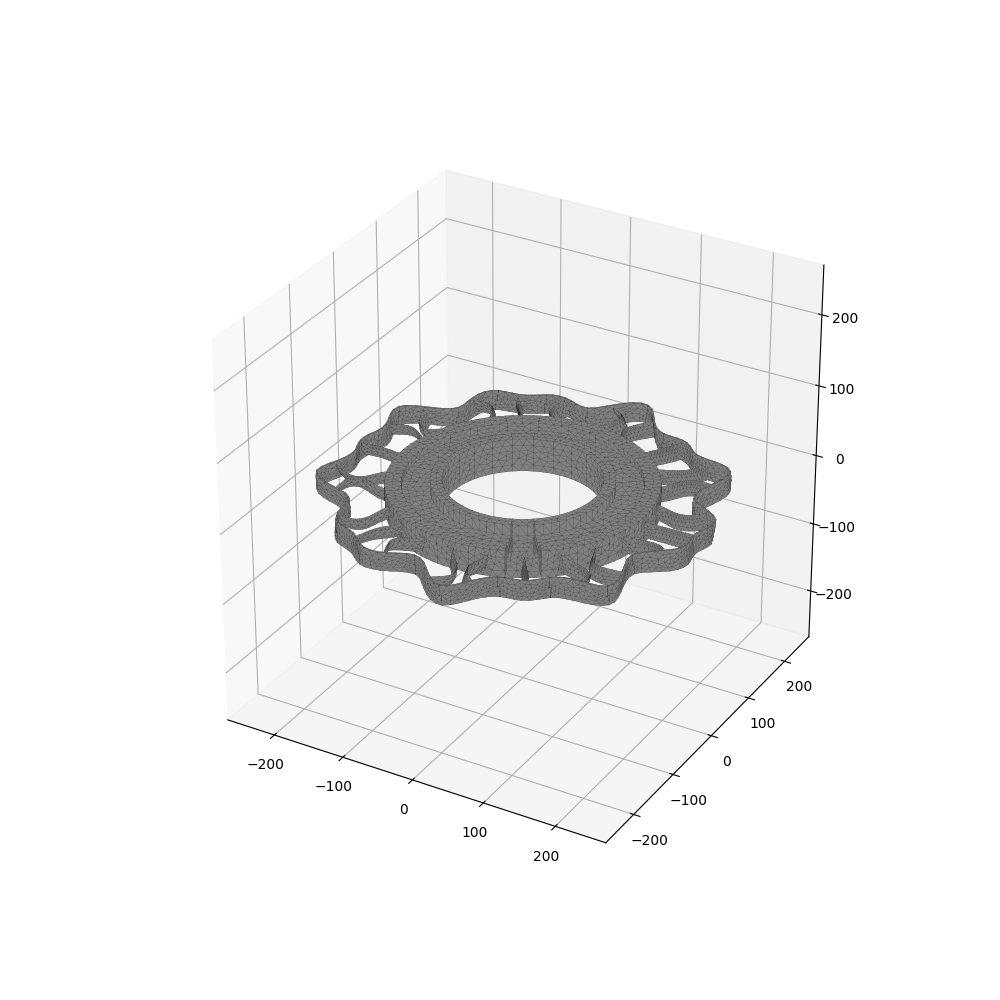

In [38]:
plot_system_list(system_list,mode_id=30,factor=1)

<IPython.core.display.Javascript object>


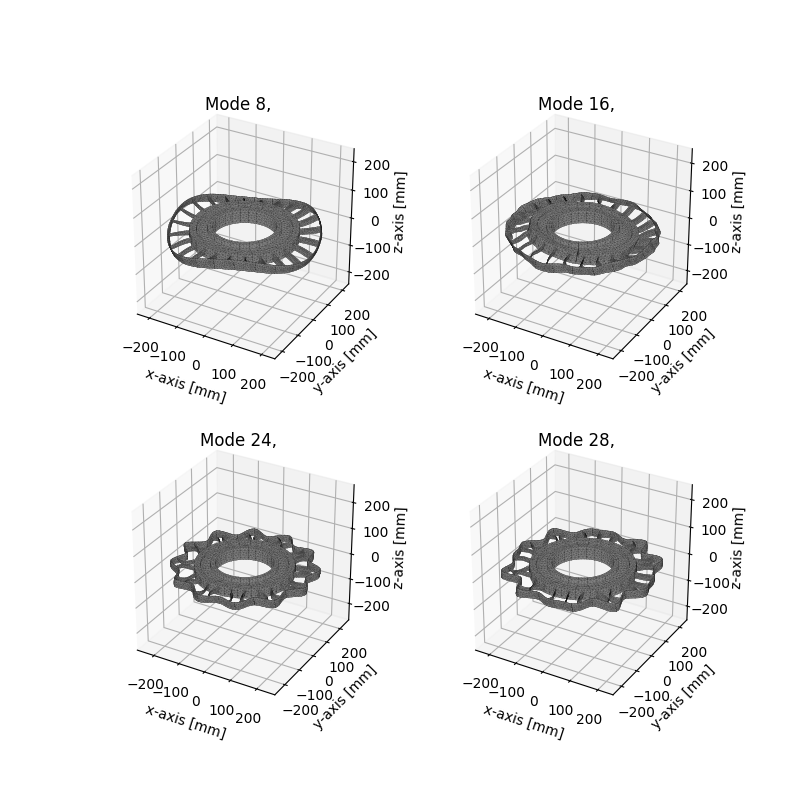

In [39]:
mode_list = [8,16,24,28]
plot_mode_list(system_list,mode_list,factor=1)

In [ ]:
#load results


V_wp_ = load_object('case_512/6_cyclic_V_wp_.pkl')
eigval_without_projection_= load_object('case_512/6_cyclic_eigval_without_projection_.pkl')
val_wp = np.sort(1.0/eigval_without_projection_.real)
val_wp

freq_wp = np.sqrt(val_wp)/(2.0*np.pi)
freq_wp

In [ ]:
system_list = update_system(system_list,V_wp_.real)

In [ ]:
plot_system_list(system_list,mode_id=1,factor=1)

In [ ]:
#load results
V = load_object('case_512/6_cyclic_V.pkl')
eigval = load_object('case_512/6_cyclic_eigval.pkl')
val = np.sort(1.0/eigval.real)
val

freq = np.sqrt(val)/(2.0*np.pi)
freq

In [ ]:
system_list = update_system(system_list,V.real)

In [ ]:
plot_system_list(system_list,mode_id=1,factor=1)

In [ ]:
plt.figure()
plt.plot(V[:,29].real,V_wp_[:,29].real,'o')
plt.show()

In [ ]:
plt.figure()
plt.plot(V[:,29].real,Vprimal[:,29].real,'o')
plt.show()

In [ ]:
plt.figure()
plt.plot(V_wp_[:,29].real,Vprimal[:,29].real,'o')
plt.show()

In [ ]:
error_1 = freq_p - freq_wp

error_1.max()

In [ ]:
error_2 = freq_p - freq
error_2.max()

In [ ]:
np.mean(error_1**2)

In [ ]:
np.mean(error_2**2)